In [1]:
import io
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense,Dropout, Input
from sklearn.utils import resample

#for model
# Import Statements
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense
import transformers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from transformers import AutoTokenizer, TFBertModel
import matplotlib.pyplot as plt

c:\Users\ivsvi\miniconda3\envs\tf-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#!pip install openpyxl

In [3]:
df_base = pd.read_json("C:\\Users\\ivsvi\\Codes\\Codes in Main drive\\Masters\\SEM-3\\DL\\Final Project\\Combined Dataset.json")

df_base = df_base.dropna() # To remove any None values
df_base.head()

,Domain,Judgement Status,Court,Judgement
0,Civil,1,Supreme Court,appeal judgment decre bombay high court stone ...
1,Civil,2,Supreme Court,applic articl 32 1 constitut enforc applic fun...
2,Civil,0,Supreme Court,appeal judgment high court hyderabad articl 37...
3,Civil,0,Supreme Court,appeal articl 3744 constitut judgment decre hi...
4,Criminal,3,Supreme Court,petit art 136 constitut pray special leav appe...


In [4]:
df_base

,Domain,Judgement Status,Court,Judgement
0,Civil,1,Supreme Court,appeal judgment decre bombay high court stone ...
1,Civil,2,Supreme Court,applic articl 32 1 constitut enforc applic fun...
2,Civil,0,Supreme Court,appeal judgment high court hyderabad articl 37...
3,Civil,0,Supreme Court,appeal articl 3744 constitut judgment decre hi...
4,Criminal,3,Supreme Court,petit art 136 constitut pray special leav appe...
...,...,...,...,...
1795,Writ,3,Calcutta High Court,The grievance of the petitioner in this writ p...
1796,Civil,2,Calcutta High Court,The said appeal was ultimately decided by the ...
1797,Writ,2,Calcutta High Court,"Mitra, Sr. Advocate with Mr. Ratnanko Banerjee..."
1798,Revision Petition,3,Calcutta High Court,Considering the averments contained in the app...


In [5]:
df_base

,Domain,Judgement Status,Court,Judgement
0,Civil,1,Supreme Court,appeal judgment decre bombay high court stone ...
1,Civil,2,Supreme Court,applic articl 32 1 constitut enforc applic fun...
2,Civil,0,Supreme Court,appeal judgment high court hyderabad articl 37...
3,Civil,0,Supreme Court,appeal articl 3744 constitut judgment decre hi...
4,Criminal,3,Supreme Court,petit art 136 constitut pray special leav appe...
...,...,...,...,...
1795,Writ,3,Calcutta High Court,The grievance of the petitioner in this writ p...
1796,Civil,2,Calcutta High Court,The said appeal was ultimately decided by the ...
1797,Writ,2,Calcutta High Court,"Mitra, Sr. Advocate with Mr. Ratnanko Banerjee..."
1798,Revision Petition,3,Calcutta High Court,Considering the averments contained in the app...


In [6]:
df_base.shape

(1789, 4)

In [7]:
print(df_base['Judgement Status'].value_counts())

Judgement Status
1    525
2    433
0    429
3    402
Name: count, dtype: int64


### There is class imbalance so first let's balance the class before training  the model

In [8]:
# Separate majority class (class 1) and minority classes (classes 0, 2, and 3)
df_majority = df_base[df_base['Judgement Status'] == 1]
df_minority_0 = df_base[df_base['Judgement Status'] == 0]
df_minority_2 = df_base[df_base['Judgement Status'] == 2]
df_minority_3 = df_base[df_base['Judgement Status'] == 3]

# Calculate the number of samples in the majority class (class 1)
majority_class_size = df_majority.shape[0]

df_majority.shape

(525, 4)

In [9]:
from sklearn.utils import resample

In [10]:
# Randomly sample from the minority classes to match the majority class size
df_minority_0_sampled = resample(df_minority_0, 
                                  replace=True,       # Sample with replacement
                                  n_samples=majority_class_size,  # Match majority class size
                                  random_state=123)   # Set random seed for reproducibility

df_minority_2_sampled = resample(df_minority_2, 
                                  replace=True, 
                                  n_samples=majority_class_size,    
                                  random_state=123)

df_minority_3_sampled = resample(df_minority_3, 
                                  replace=True, 
                                  n_samples=majority_class_size,    
                                  random_state=123)

# Combine the majority class with the resampled minority classes
df_balanced = pd.concat([df_majority, df_minority_0_sampled, df_minority_2_sampled, df_minority_3_sampled])

# Verify the new class distribution

print(df_balanced['Judgement Status'].value_counts())

Judgement Status
1    525
0    525
2    525
3    525
Name: count, dtype: int64


In [11]:
df_base = df_balanced
df_base.shape

(2100, 4)

In [12]:
#df_base = df_base.rename(columns={'text': 'Judgement', 'label': 'Judgement Status'})

In [13]:
# Complete Data
from sklearn.model_selection import train_test_split
sentences = df_base[['Judgement','Judgement Status']]

# Train and Test Split for Abstractive Data
df_train, df_test = train_test_split(sentences, test_size=0.25, random_state=42)

# Complete Data
y_train = to_categorical(df_train['Judgement Status'])
y_test = to_categorical(df_test['Judgement Status'])

In [14]:
df_base = df_base.rename(columns = {'Judgement Status': 'label', 'Judgement': 'text'}, inplace = False)
print('Available labels: ',df_base.label.unique())

num_classes_base = len(df_base.label.unique())
df_base.head()

Available labels:  [1 0 2 3]


,Domain,label,Court,text
0,Civil,1,Supreme Court,appeal judgment decre bombay high court stone ...
6,Civil,1,Supreme Court,appeal civil appeal 31 1950 judgment decre dat...
7,Criminal,1,Supreme Court,appeal crimin appeal 3 1950 judgment high cour...
11,Criminal,1,Supreme Court,appeal crimin appeal 1 1950 special leav order...
12,Civil,1,Supreme Court,appeal judgment decre date 12th januari 1948 h...


In [15]:
max_len = 512
sentences_base = df_base['text']
labels_base = df_base['label']
len(sentences_base), len(labels_base)

(2100, 2100)

In [16]:
df_base

,Domain,label,Court,text
0,Civil,1,Supreme Court,appeal judgment decre bombay high court stone ...
6,Civil,1,Supreme Court,appeal civil appeal 31 1950 judgment decre dat...
7,Criminal,1,Supreme Court,appeal crimin appeal 3 1950 judgment high cour...
11,Criminal,1,Supreme Court,appeal crimin appeal 1 1950 special leav order...
12,Civil,1,Supreme Court,appeal judgment decre date 12th januari 1948 h...
...,...,...,...,...
557,Civil,3,Orissa High Court,date hear 21082019 date judgment 18122019 dr a...
156,Criminal,3,Delhi District Court,second applic bail prefer accus ankit handa fi...
549,Revision Petition,3,Madras High Court,petit file seek direct set asid order date 268...
756,Criminal,3,Delhi District Court,Learned counsel for the accused next argued th...


In [17]:
df_train_base, df_test_base = train_test_split(df_base, test_size=0.2, random_state=42)

In [18]:
df_train_base.shape

(1680, 4)

## Run the tokenizer with all sentences

In [19]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [20]:
def tokenize_BERT(df_column, max_length, tokenizer):
    tokenized_output = tokenizer(
        text=df_column.tolist(),
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )
    return tokenized_output

In [21]:
x_train_base_bert = tokenize_BERT(df_train_base['text'], max_length=200, tokenizer=bert_tokenizer)
x_test_base_bert = tokenize_BERT(df_test_base['text'], max_length=200, tokenizer=bert_tokenizer)

# Extractive Data
y_train_base = to_categorical(df_train_base['label'])
y_test_base = to_categorical(df_test_base['label'])

In [22]:
input_ids_base_bert = x_train_base_bert['input_ids']
attention_mask_base_bert = x_test_base_bert['attention_mask']

In [23]:
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Dense, Dropout, GlobalMaxPool1D, Input
max_len = 200

input_ids_bert = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask_bert = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

# BERT embeddings
embeddings = bert_model(input_ids_bert, attention_mask=input_mask_bert)[0]
out = GlobalMaxPool1D()(embeddings)

# Add L2 regularization to Dense layers
regularization_strength = 0.01  # You can change this value as per your needs

# Layer-1 with L2 regularization
#out = Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(regularization_strength))(out)
#out = Dropout(0.2)(out)

# Layer-2 with L2 regularization
out = Dense(512, activation='relu', 
            kernel_regularizer=regularizers.l2(regularization_strength))(out)
out = Dropout(0.2)(out)

out = Dense(256, activation='relu', 
            kernel_regularizer=regularizers.l2(regularization_strength))(out)
out = Dropout(0.2)(out)

# Layer-3 with L2 regularization
out = Dense(128, activation='relu', 
            kernel_regularizer=regularizers.l2(regularization_strength))(out)
# Dropout layer
out = Dropout(0.2)(out)


# Layer-4 with L2 regularization
out = Dense(32, activation='relu', 
            kernel_regularizer=regularizers.l2(regularization_strength))(out)
out = Dropout(0.2)(out)
# Output layer
y = Dense(4, activation='sigmoid')(out)

# Create the model
model_bert = tf.keras.Model(inputs=[input_ids_bert, input_mask_bert], outputs=y)

# Set the third layer's weights to be trainable
model_bert.layers[1].trainable = True  # Layer 1 (Dense layer after BERT embeddings)
model_bert.layers[2].trainable = True

In [24]:
bert_optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
bert_loss = CategoricalCrossentropy(from_logits = True)
bert_metric = CategoricalAccuracy('balanced_accuracy')

early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=5,          # Stop training after 3 epochs of no improvement
    restore_best_weights=True
)

reduce_lrearning_rate = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor validation loss
    factor=0.5,          # Reduce learning rate by half
    patience=2,          # After 2 epochs of no improvement
    min_lr=1e-6          # Minimum learning rate
)

# extpile the model
model_bert.compile(
    optimizer = bert_optimizer,
    loss=bert_loss,
    metrics = bert_metric)
model_bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 200)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 200)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 200,                                           

In [25]:
# train_mask_base.shape

In [26]:
history_data_base = model_bert.fit(
    x ={'input_ids':x_train_base_bert['input_ids'],'attention_mask':x_train_base_bert['attention_mask']} ,
    y = y_train_base,
    validation_data = (
    {'input_ids':x_test_base_bert['input_ids'],'attention_mask':x_test_base_bert['attention_mask']}, y_test_base
    ),
  epochs=50,
    batch_size=10,
    callbacks=[early_stopping, reduce_lrearning_rate],  # Add callbacks here
    verbose=1
)

Epoch 1/50


c:\Users\ivsvi\miniconda3\envs\tf-gpu\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


168/168 [==============================] - 45s 209ms/step - loss: 12.6234 - balanced_accuracy: 0.2411 - val_loss: 12.1279 - val_balanced_accuracy: 0.2976 - lr: 5.0000e-05
Epoch 2/50
168/168 [==============================] - 34s 204ms/step - loss: 11.8495 - balanced_accuracy: 0.2625 - val_loss: 11.5707 - val_balanced_accuracy: 0.3000 - lr: 5.0000e-05
Epoch 3/50
168/168 [==============================] - 34s 202ms/step - loss: 11.4177 - balanced_accuracy: 0.2964 - val_loss: 11.2537 - val_balanced_accuracy: 0.2929 - lr: 5.0000e-05
Epoch 4/50
168/168 [==============================] - 34s 205ms/step - loss: 11.1542 - balanced_accuracy: 0.3161 - val_loss: 11.0244 - val_balanced_accuracy: 0.3048 - lr: 5.0000e-05
Epoch 5/50
168/168 [==============================] - 34s 202ms/step - loss: 10.9254 - balanced_accuracy: 0.3476 - val_loss: 10.7761 - val_balanced_accuracy: 0.4190 - lr: 5.0000e-05
Epoch 6/50
168/168 [==============================] - 34s 202ms/step - loss: 10.6844 - balanced_accur

In [27]:
predicted_raw_base_bert = model_bert.predict({'input_ids':x_test_base_bert['input_ids'],'attention_mask':x_test_base_bert['attention_mask']})
predicted_raw_base_bert[0]

14/14 [==============================] - 4s 190ms/step


array([0.624466  , 0.9755795 , 0.09528281, 0.5198122 ], dtype=float32)

In [28]:
#preds_base = model_bert.predict([val_inp_base,val_mask_base],batch_size=16)
import numpy as np

In [29]:
y_predicted_base_bert = np.argmax(predicted_raw_base_bert, axis = 1)
y_true_base_bert = df_test_base['label']

In [30]:
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

In [31]:
print(classification_report(y_true_base_bert, y_predicted_base_bert))

print("F1 Score: ",f1_score(y_true_base_bert,y_predicted_base_bert, average='macro'))

              precision    recall  f1-score   support

           0       0.69      0.68      0.68       100
           1       0.67      0.62      0.65       112
           2       0.87      0.70      0.78       114
           3       0.65      0.86      0.74        94

    accuracy                           0.71       420
   macro avg       0.72      0.72      0.71       420
weighted avg       0.72      0.71      0.71       420

F1 Score:  0.712099167732744


In [32]:
x_test_base_bert = {'input_ids':x_test_base_bert['input_ids'],'attention_mask':x_test_base_bert['attention_mask']}

test_loss_base_bert, test_accuracy_base_bert = model_bert.evaluate(x_test_base_bert, y_test_base, verbose=False)
print("Testing Accuracy:  {:.4f}".format(test_accuracy_base_bert))

c:\Users\ivsvi\miniconda3\envs\tf-gpu\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Testing Accuracy:  0.7119


In [33]:
predicted_raw_base_bert_trainData = model_bert.predict({'input_ids':x_train_base_bert['input_ids'],'attention_mask':x_train_base_bert['attention_mask']})
predicted_raw_base_bert_trainData[0]

53/53 [==============================] - 11s 202ms/step


array([0.10668131, 0.30001676, 0.24323088, 0.9711349 ], dtype=float32)

In [34]:
y_predicted_base_bert_trainData = np.argmax(predicted_raw_base_bert_trainData, axis = 1)
y_true_base_bert_trainData = df_train_base['label']

In [35]:
print(classification_report(y_true_base_bert_trainData, y_predicted_base_bert_trainData))

print("F1 Score: ",f1_score(y_true_base_bert_trainData,y_predicted_base_bert_trainData, average='macro'))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       425
           1       0.94      0.93      0.93       413
           2       1.00      0.94      0.97       411
           3       0.93      1.00      0.96       431

    accuracy                           0.95      1680
   macro avg       0.95      0.95      0.95      1680
weighted avg       0.95      0.95      0.95      1680

F1 Score:  0.9499962524875435


In [36]:
x_train_base_bert = {'input_ids':x_train_base_bert['input_ids'],'attention_mask':x_train_base_bert['attention_mask']}
train_loss_base_bert, train_accuracy_base_bert = model_bert.evaluate(x_train_base_bert, y_train_base, verbose=False)
print("Training Accuracy: {:.4f}".format(train_accuracy_base_bert))

Training Accuracy: 0.9500


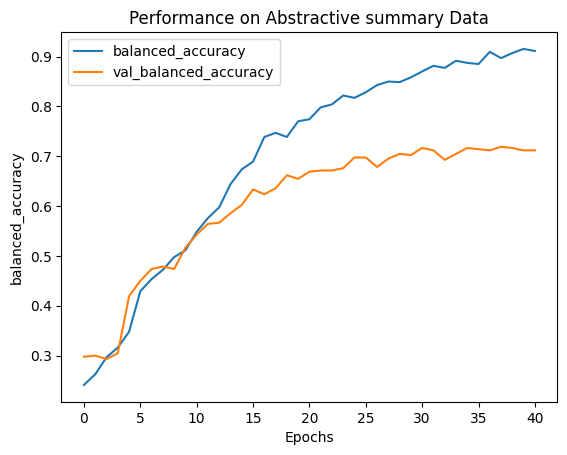

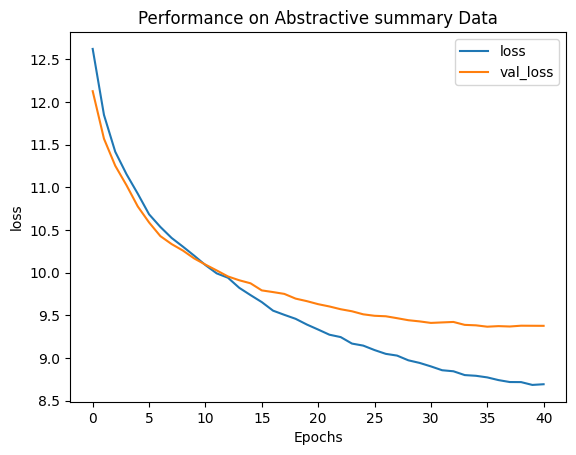

In [37]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.title("Performance on Abstractive summary Data")
    plt.show()
    
plot_graphs(history_data_base, "balanced_accuracy")
plot_graphs(history_data_base, "loss")

In [38]:
model_bert.save("C:/Users/ivsvi/Codes/Codes in Main drive/Masters/SEM-3/DL/Final Project/Saved Models/EntireData.h5")

# Plot

In [39]:
file_path = "C:\\Users\\ivsvi\\Codes\\Codes in Main drive\\Masters\\SEM-3\\DL\\Final Project\\Combined Dataset.json"
data_plt = pd.read_json(file_path)

# Show the first few rows of the dataset to understand its structure
data_plt.head()

,Domain,Judgement Status,Court,Judgement
0,Civil,1,Supreme Court,appeal judgment decre bombay high court stone ...
1,Civil,2,Supreme Court,applic articl 32 1 constitut enforc applic fun...
2,Civil,0,Supreme Court,appeal judgment high court hyderabad articl 37...
3,Civil,0,Supreme Court,appeal articl 3744 constitut judgment decre hi...
4,Criminal,3,Supreme Court,petit art 136 constitut pray special leav appe...


In [40]:
data_plt.shape

(1800, 4)

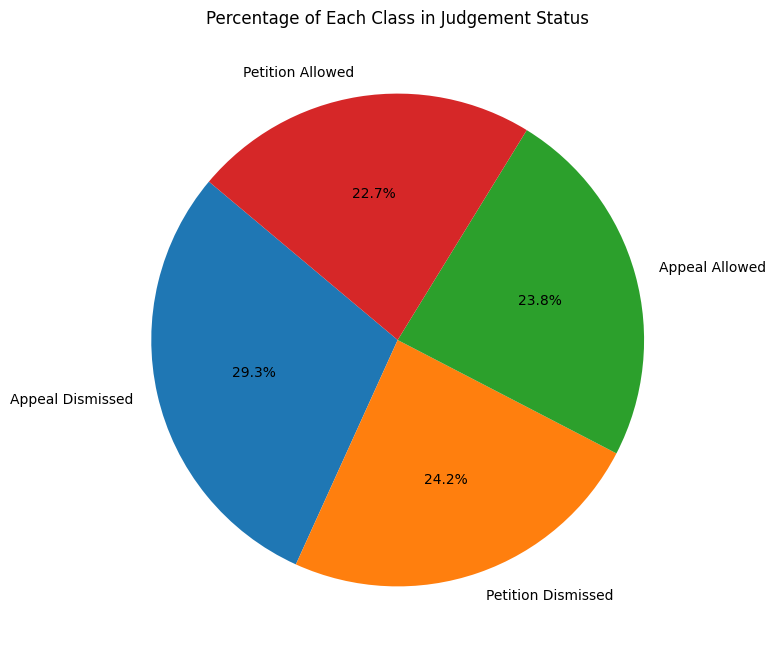

In [41]:
judgement_status_counts = data_plt['Judgement Status'].value_counts()
judgement_status_labels = judgement_status_counts.index.astype(str)
judgement_status_percentages = judgement_status_counts.values

# Mapping for class labels
class_labels = {
    '3': 'Petition Allowed',
    '0': 'Appeal Allowed',
    '2': 'Petition Dismissed',
    '1': 'Appeal Dismissed'
}

# Map the judgement status labels to the new descriptive labels
judgement_status_labels_named = [class_labels[str(label)] for label in judgement_status_labels]

# Plot the pie chart with updated labels
plt.figure(figsize=(8, 8))
plt.pie(judgement_status_percentages, labels=judgement_status_labels_named, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Each Class in Judgement Status')
plt.show()

In [42]:
df = pd.read_excel("C:\\Users\\ivsvi\\Codes\\Codes in Main drive\\Masters\\SEM-3\\DL\\Final Project\\Combined Dataset.xlsx", header=0,index_col=0)
#df = df[0:600]

In [43]:
df.shape

(1800, 4)

In [44]:
df

,Domain,Judgement Status,Court,Judgement
Id,,,,
1,Civil,1,Supreme Court,appeal judgment decre bombay high court stone ...
2,Civil,2,Supreme Court,applic articl 32 1 constitut enforc applic fun...
3,Civil,0,Supreme Court,appeal judgment high court hyderabad articl 37...
4,Civil,0,Supreme Court,appeal articl 3744 constitut judgment decre hi...
5,Criminal,3,Supreme Court,petit art 136 constitut pray special leav appe...
...,...,...,...,...
1796,Writ,3,Calcutta High Court,The grievance of the petitioner in this writ p...
1797,Civil,2,Calcutta High Court,The said appeal was ultimately decided by the ...
1798,Writ,2,Calcutta High Court,"Mitra, Sr. Advocate with Mr. Ratnanko Banerjee..."


In [45]:
df=df.dropna()

In [46]:
x_collected = tokenize_BERT(df['Judgement'], max_length=200, tokenizer=bert_tokenizer)
input_ids_collected_bert = x_collected['input_ids']
attention_mask_collected_bert = x_collected['attention_mask']

In [47]:
predictions = model_bert.predict({'input_ids': input_ids_collected_bert, 'attention_mask': attention_mask_collected_bert})

56/56 [==============================] - 12s 207ms/step


In [48]:
y_predicted_base_bert_collected = np.argmax(predictions, axis = 1)
y_true_base_bert_collected = df['Judgement Status']

In [49]:
y_predicted_base_bert_collected

array([1, 2, 1, ..., 2, 3, 3], dtype=int64)

In [50]:
y_true_base_bert_collected

Id
1       1
2       2
3       0
4       0
5       3
       ..
1796    3
1797    2
1798    2
1799    3
1800    3
Name: Judgement Status, Length: 1789, dtype: int64

In [51]:
print(classification_report(y_true_base_bert_collected, y_predicted_base_bert_collected))

print("F1 Score: ",f1_score(y_true_base_bert_collected, y_predicted_base_bert_collected, average='macro'))

              precision    recall  f1-score   support

           0       0.82      0.68      0.75       429
           1       0.74      0.86      0.79       525
           2       0.85      0.73      0.79       433
           3       0.74      0.81      0.77       402

    accuracy                           0.78      1789
   macro avg       0.78      0.77      0.77      1789
weighted avg       0.78      0.78      0.78      1789

F1 Score:  0.7738388359680504


In [52]:
from sklearn.metrics import classification_report, f1_score, accuracy_score

In [53]:
accuracy = accuracy_score(y_true_base_bert_collected, y_predicted_base_bert_collected)
print("Accuracy: ", accuracy)

Accuracy:  0.7758524315259921


# Explainable AI

In [54]:
y_test.shape

(525, 4)

In [55]:
y_test

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [64]:
df_test_base.iloc[2]['text'] 

'debasish kar gupta j appeal direct convict appel commiss offenc punish section 30244834 indian penal code hereinaft refer ipc sentenc suffer imprison life commiss offenc punish section 302 0f ipc pay fine rs2000 default suffer simpl imprison six month pay 50 aforesaid fine realis widow victim sentenc suffer simpl imprison six month commiss offenc punish section 448 ipc also sentenc appel no1 suffer simpl imprison six month commiss offenc punish section 323 ipc direct run aforesaid sentenc appel concurr pass addit session judg fast track court no2 purulia session trial no6 2004 aris session case no149 2001 accord prosecut case juli 10 2000 0030 hour one chkradhar mudi deceas villagebanbah polic station purulia muffasil districtpurulia son pw 1 sleep separ cot tile shed besid khamar dwell hous suddenli appel also yudhisthir mudi sinc deceas resid adjac hous came aforesaid dwell hous victim arm rod spade tangi appel srikanta mudi kanta mudi assault pw 1 left cheek blunt side tangi fell c

In [67]:
import numpy as np
from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer
import tensorflow as tf

# Initialize the LIME text explainer
explainer = LimeTextExplainer(class_names=['0-Appeal allowed', '1-Appeal dismissed', '2-Petition dismissed', '3-Petition allowed'])  # Replace with your class names

# Adjusted prediction function for LIME
def predict_proba(texts):
    # Tokenize the input texts (list of strings)
    tokenized_input = bert_tokenizer(
        texts,  # LIME provides raw text
        add_special_tokens=True,
        max_length=200,
        truncation=True,
        padding=True,
        return_tensors='tf'
    )
    
    input_ids = tokenized_input['input_ids']
    attention_mask = tokenized_input['attention_mask']
    
    # Get predictions from the model
    predictions = model_bert.predict({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    # Return probabilities
    return predictions

# Explain a specific instance (change `textractive_to_explain` to the text you want to explain)
text_to_explain = df_test_base.iloc[2]['text']  # Example text from your test dataset

# Generate explanations
exp = explainer.explain_instance(
    text_instance= text_to_explain,
    classifier_fn=predict_proba,
    num_features=15  # Number of words to highlight in the explanation
)

# Visualize the explanation
exp.show_in_notebook()


157/157 [==============================] - 32s 206ms/step


In [68]:
df_test_base

,Domain,label,Court,text
610,Criminal,0,Supreme Court,The charges in the second case were that the a...
565,Writ,2,Orissa High Court,way writ petit petition associ challeng minut ...
145,Criminal,1,Calcutta High Court,debasish kar gupta j appeal direct convict app...
1396,Income Tax,2,Punjab-Haryana High Court,"1,27,313 paid to the said firm by the assessee..."
548,Criminal,0,Supreme Court,judgment 1998 supp 3 scr 241 judgment court de...
...,...,...,...,...
910,Constitution,1,Supreme Court,"""1. This application under Article 32 of the C..."
1050,Criminal,3,Gujarat High Court,It appears that thereafter again the circular ...
168,Constitution,1,Supreme Court,order 1 appeal region provid fund commission u...
668,Criminal,1,Supreme Court,A public servant is said to commit the offence...
